<a href="https://colab.research.google.com/github/mmender2/DataScience/blob/main/EnsembleClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install tqdm

# Imports of Libraries

In [2]:
import os, sys, time, copy
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import manifold
from sklearn import decomposition
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



# Load Data and Take Quick Look at Data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/au_train.csv')
test = pd.read_csv('/content/drive/MyDrive/au_test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (32561, 15)
Test shape: (16281, 15)


In [4]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Summary Function for Data Analysis

In [5]:
def summary(df):
    print(f"Data shape: {df.shape}")
    print("\nSummary of columns missing values")
    print(df[df.isna().sum()[df.isna().sum() > 0].index].dtypes)
    print()
    summ = pd.DataFrame(df.dtypes, columns=['Data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values

    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values

    return summ

Prints the shape of the DataFrame (df.shape), which gives the number of rows and columns in the DataFrame.

Prints a summary of columns with missing values. It identifies the columns that have missing values (df.isna().sum()[df.isna().sum() > 0].index), retrieves their data types, and prints them.

Creates a summary DataFrame (summ) that contains information about the data types, missing values, and unique values for each column in the DataFrame.

Computes the number of missing values (df.isnull().sum().values) and the percentage of missing values relative to the total number of rows in the DataFrame (df.isnull().sum().values / len(df) * 100), and adds these values to the summary DataFrame (summ).

Computes the number of unique values in each column (df.nunique().values) and adds this information to the summary DataFrame (summ).

Creates another DataFrame (desc) by using the describe method on the DataFrame, which provides various statistics such as count, mean, standard deviation, minimum, first quartile (25th percentile), median (second quartile or 50th percentile), and third quartile (75th percentile) for numeric columns.

Transposes the DataFrame and assigns it to desc.

Adds the minimum, maximum, and quartile values from the desc DataFrame to the summary DataFrame (summ).

Returns the summary DataFrame (summ).

In [6]:
summary(train)

Data shape: (32561, 15)

Summary of columns missing values
Series([], dtype: object)



,Data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
age,int64,0,0.0,73,17.0,90.0,28.0,37.0,48.0
workclass,object,0,0.0,9,NaN,NaN,NaN,NaN,NaN
fnlwgt,int64,0,0.0,21648,12285.0,1484705.0,117827.0,178356.0,237051.0
education,object,0,0.0,16,NaN,NaN,NaN,NaN,NaN
education-num,int64,0,0.0,16,1.0,16.0,9.0,10.0,12.0
marital-status,object,0,0.0,7,NaN,NaN,NaN,NaN,NaN
occupation,object,0,0.0,15,NaN,NaN,NaN,NaN,NaN
relationship,object,0,0.0,6,NaN,NaN,NaN,NaN,NaN
race,object,0,0.0,5,NaN,NaN,NaN,NaN,NaN
sex,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN


# Identify Numerical and Categorical Variables

In [7]:
# select numerical and categorical features
num_cols = test.select_dtypes(include=np.number).columns.tolist()
cat_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Id' in cat_cols:
    cat_cols.remove('Id')
print(f"Total numerical features: {len(num_cols)}")
print(f"Total categorical features: {len(cat_cols)}")
print(num_cols)
print(cat_cols)

Total numerical features: 6
Total categorical features: 9
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']


        class  pct (%)
 <=50K  24720   75.919
 >50K    7841   24.081 



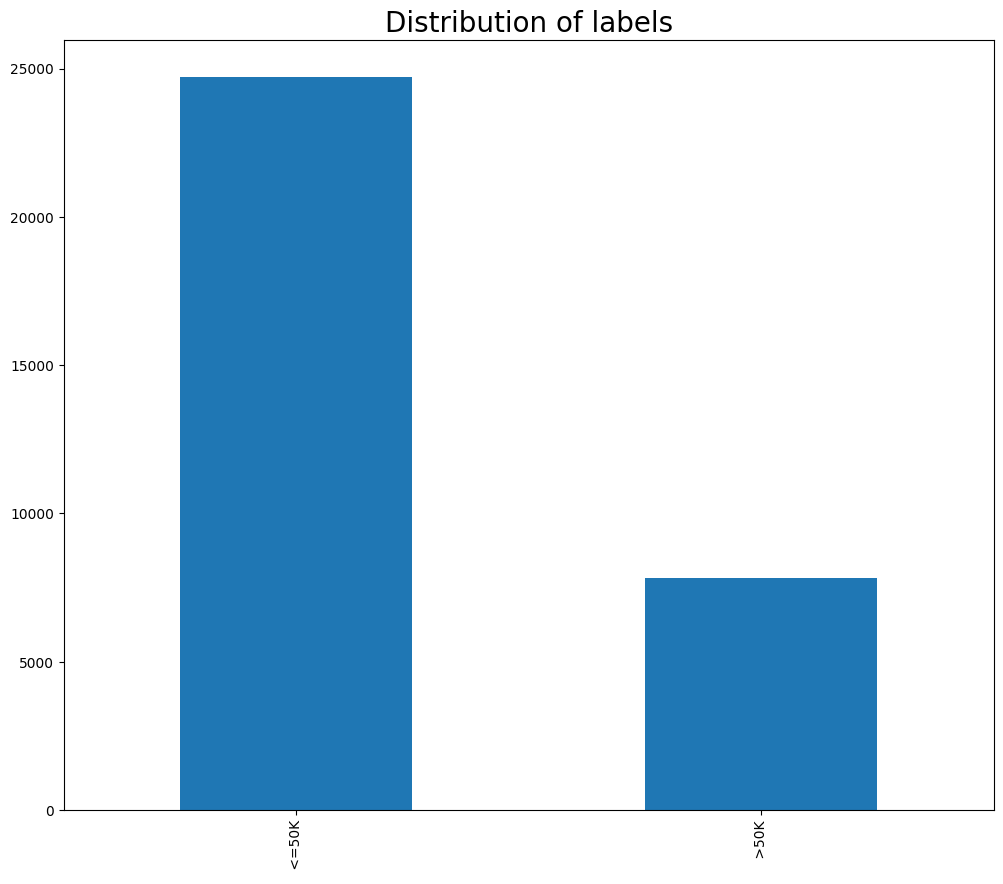

In [8]:
df = pd.DataFrame(train['class'].value_counts())
df['pct (%)'] = np.round((train['class'].value_counts()/train.shape[0]).values * 100, 4)
print(df, "\n")
plt.title('Distribution of labels', fontsize=20)
train['class'].value_counts().plot(kind='bar');

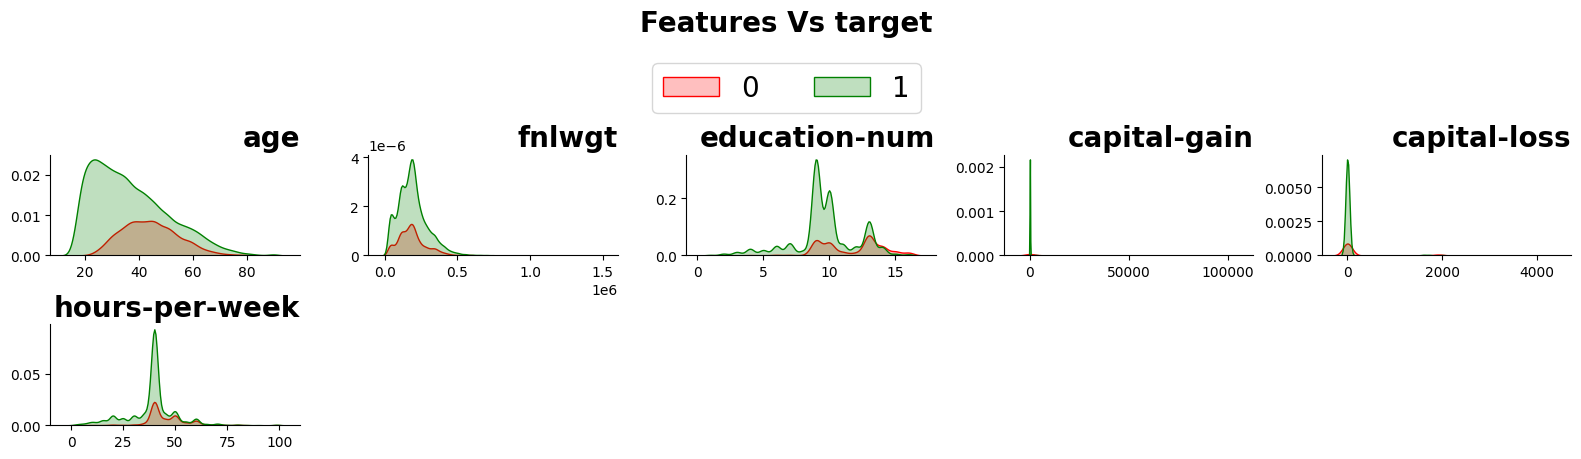

In [9]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(11, 5, idx + 1)
    sns.kdeplot(
        data=train, hue='class', fill=True,
        x=col, palette=['green', 'red'], legend=False
    )

    ax.set_ylabel(''); ax.spines['top'].set_visible(False)
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', weight='bold', fontsize=20)

fig.suptitle(f'Features Vs target\n\n\n', ha='center', fontweight='bold', fontsize=20)
fig.legend([0, 1], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=20, ncol=3)
plt.tight_layout()
plt.show()

This plot provides a visual representation of the distribution of numerical features in relation to the target variable. It helps in understanding the relationship between the features and the target, and can provide insights into how different feature values may be associated with different target variable values.

In [10]:
def visualize_outliers(df1, num_cols=num_cols):
    cols = 4
    rows = len(num_cols) // cols + 1
    plt.figure(figsize=(10,20))
    for idx, feature in enumerate(num_cols):
        ax = plt.subplot(rows, cols, idx+1)
        sns.boxplot(
            data=df1, x='class', y=feature
        )
        ax.set_title(feature)
#         ax.set_xticks([0, 1], ['Faulty', 'Un-Faulty'])
        ax.set_ylabel("Distribution")

    # plt.suptitle('Checking for outliers', fontsize=14)
    plt.tight_layout()
    plt.show()

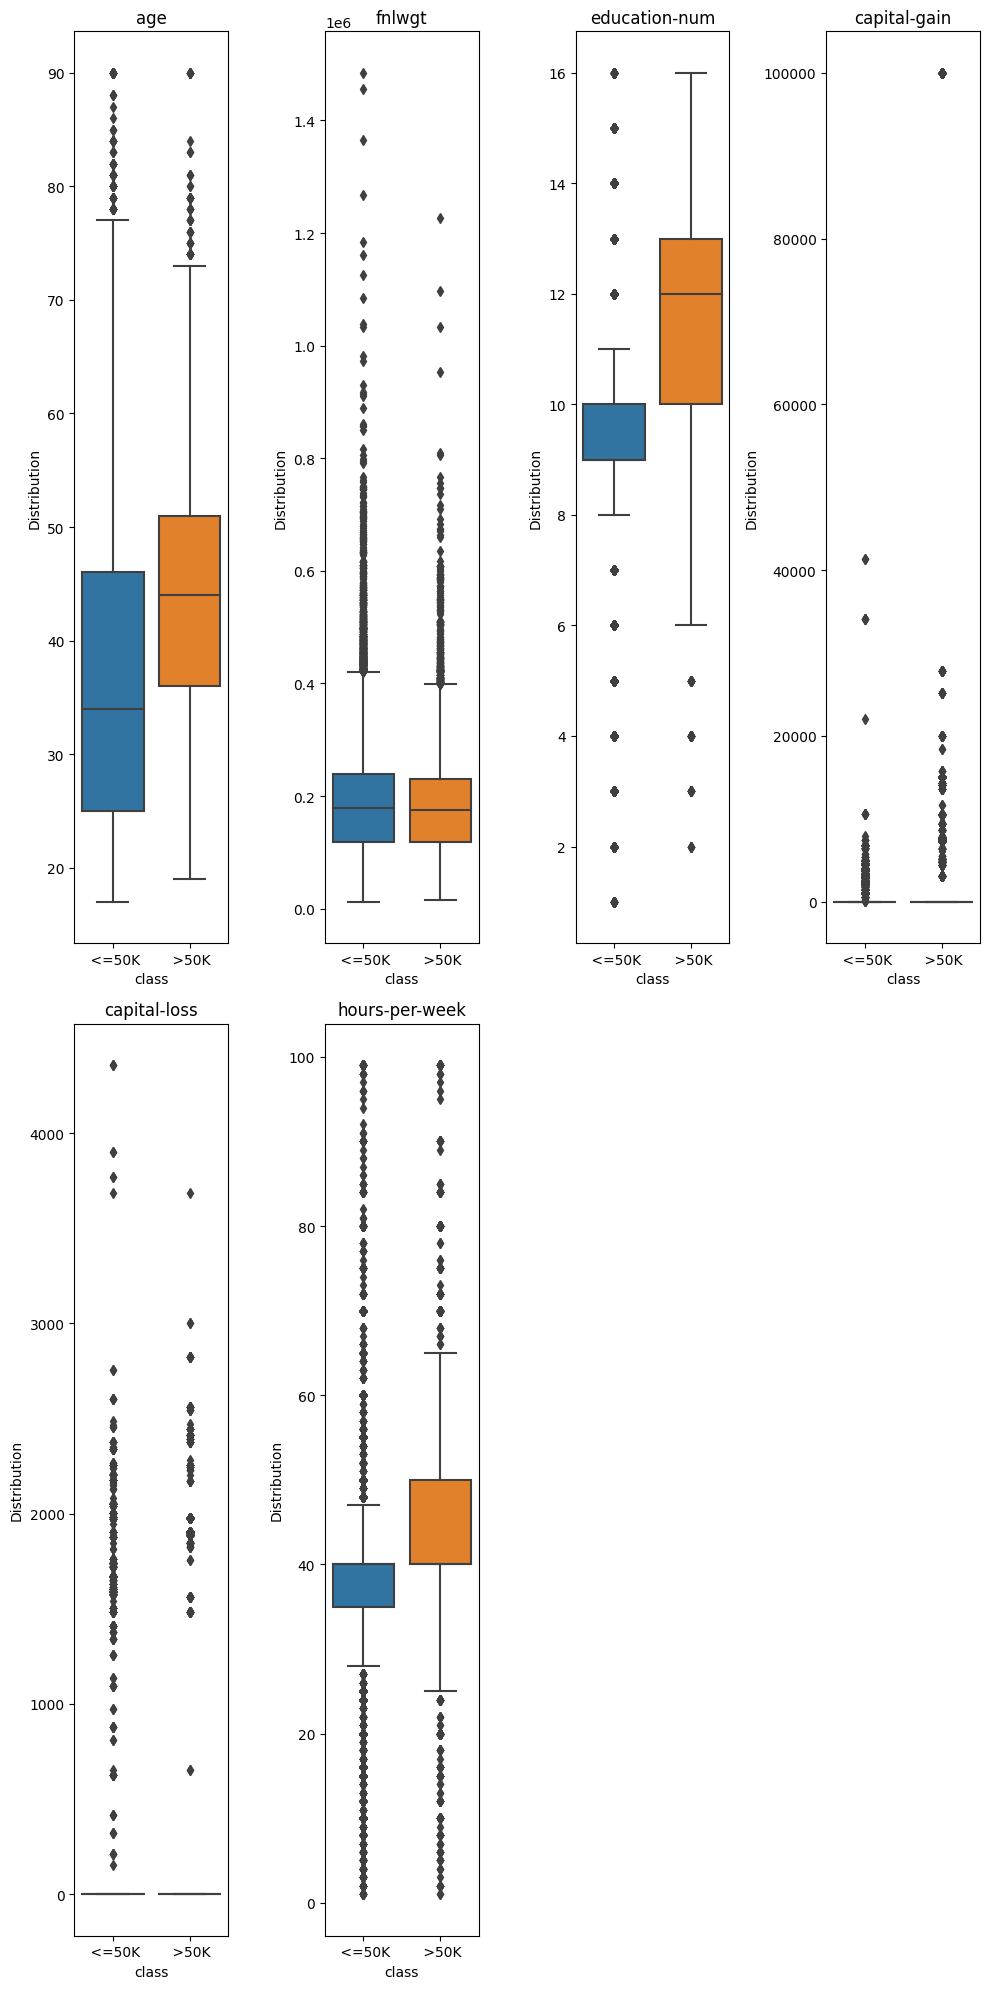

In [11]:
visualize_outliers(train)

This plot helps visualize the distribution of numerical features across different categories of the 'class' variable. It allows for a comparison of the central tendency, spread, and potential outliers in the numerical features for each category.

It can help identify differences or patterns in the distributions that may be indicative of outliers or variations between the categories.

In [12]:
def show_histogram(df1, num_cols=num_cols):
    cols = 4
    rows = len(num_cols) // cols + 1
    plt.figure(figsize=(10,20))
    for idx, feature in enumerate(num_cols):
        ax = plt.subplot(rows, cols, idx+1)
        sns.histplot(
            data=df1[feature], kde=True
        )

        ax.set_ylabel("count")

    plt.tight_layout()
    plt.show()

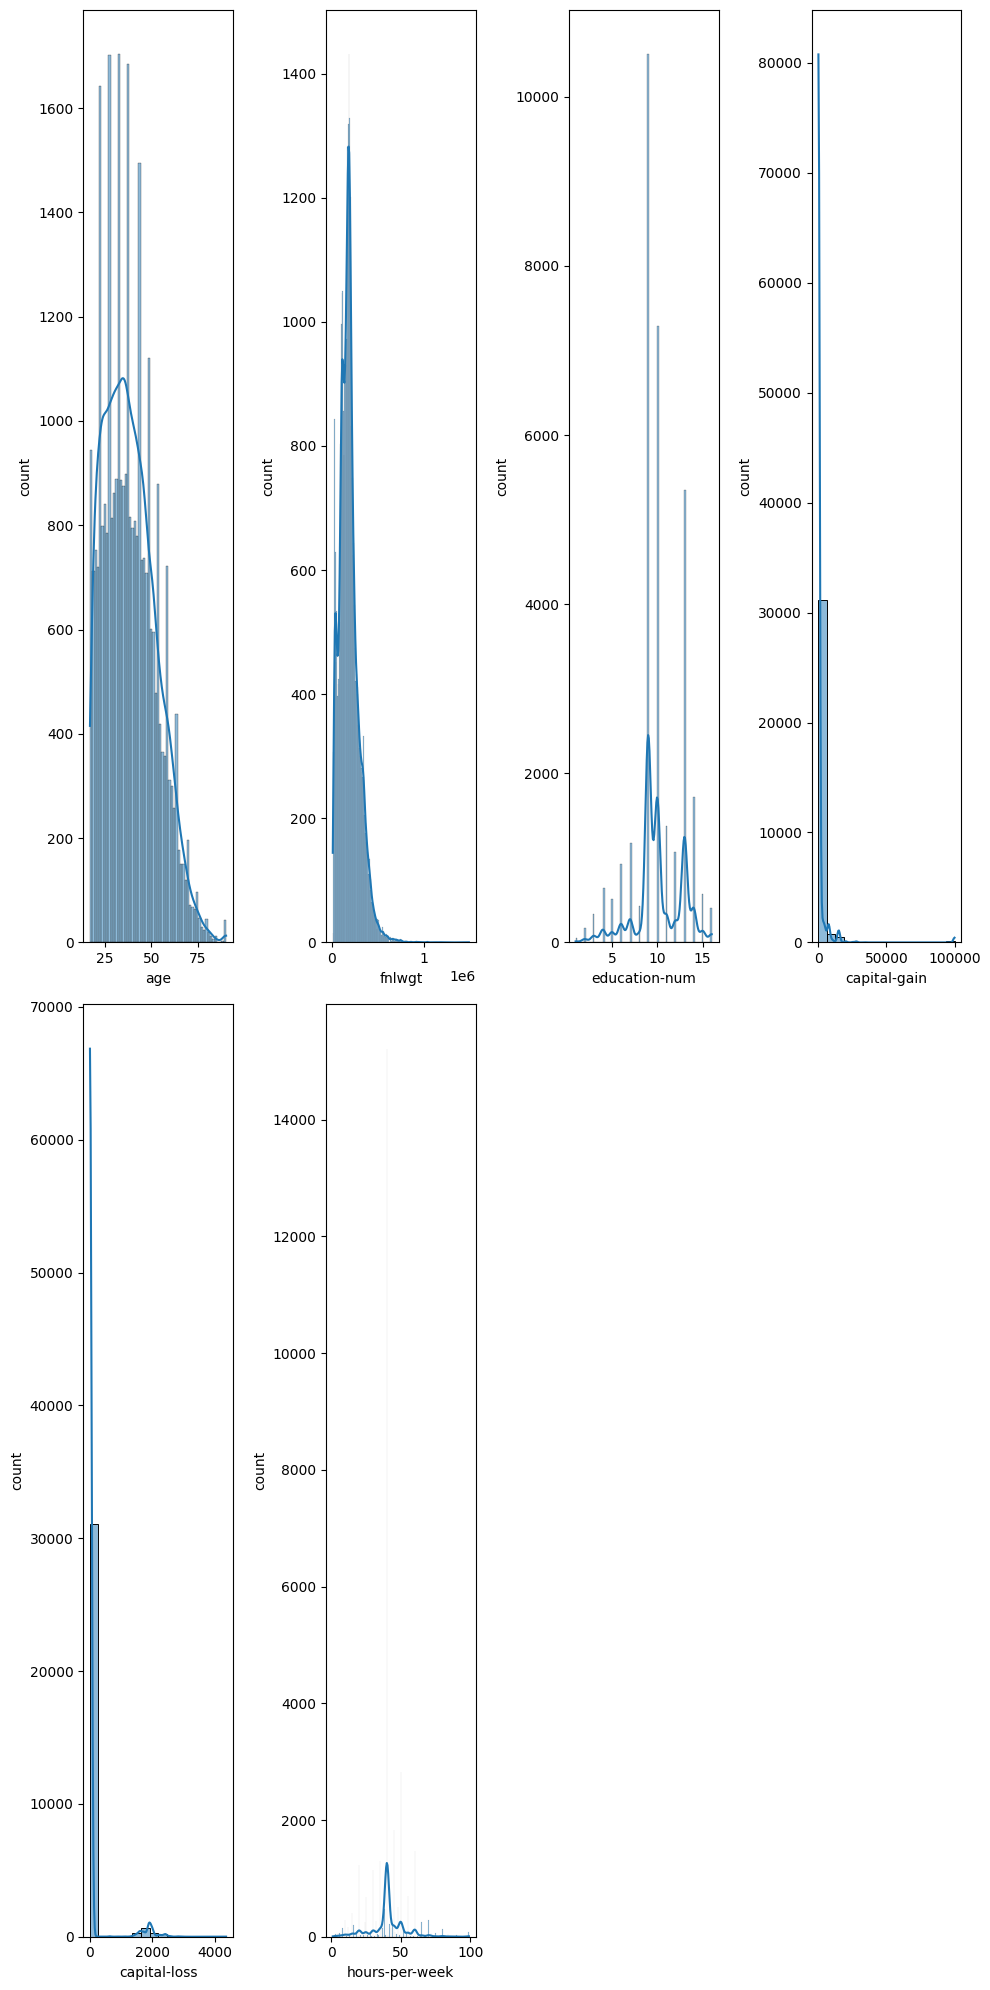

In [13]:
show_histogram(train)

This plot helps visualize the distribution of numerical features individually.

It provides insights into the shape, spread, and central tendency of each feature's distribution.

Histograms are useful for identifying patterns, skewness, or outliers in the data.

In [127]:
std_scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
quantile_scaler = preprocessing.QuantileTransformer(n_quantiles=60, output_distribution='uniform')

These scaler objects can be used to preprocess numerical data before feeding it into machine learning models. Each scaler has its own advantages and use cases, depending on the characteristics of the data and the requirements of the model.

In [128]:
scaled_train_df = train.copy(deep=True)
scaled_test_df = test.copy(deep=True)
scaled_train_df[num_cols] = quantile_scaler.fit_transform(scaled_train_df[num_cols])
scaled_test_df[num_cols] = quantile_scaler.fit_transform(scaled_test_df[num_cols])

The code scales the numerical columns in both the training and test DataFrames based on their quantile ranks.

This transformation can help normalize the distributions and make the data more suitable for certain modeling algorithms or analysis techniques.

# Check For Outliers

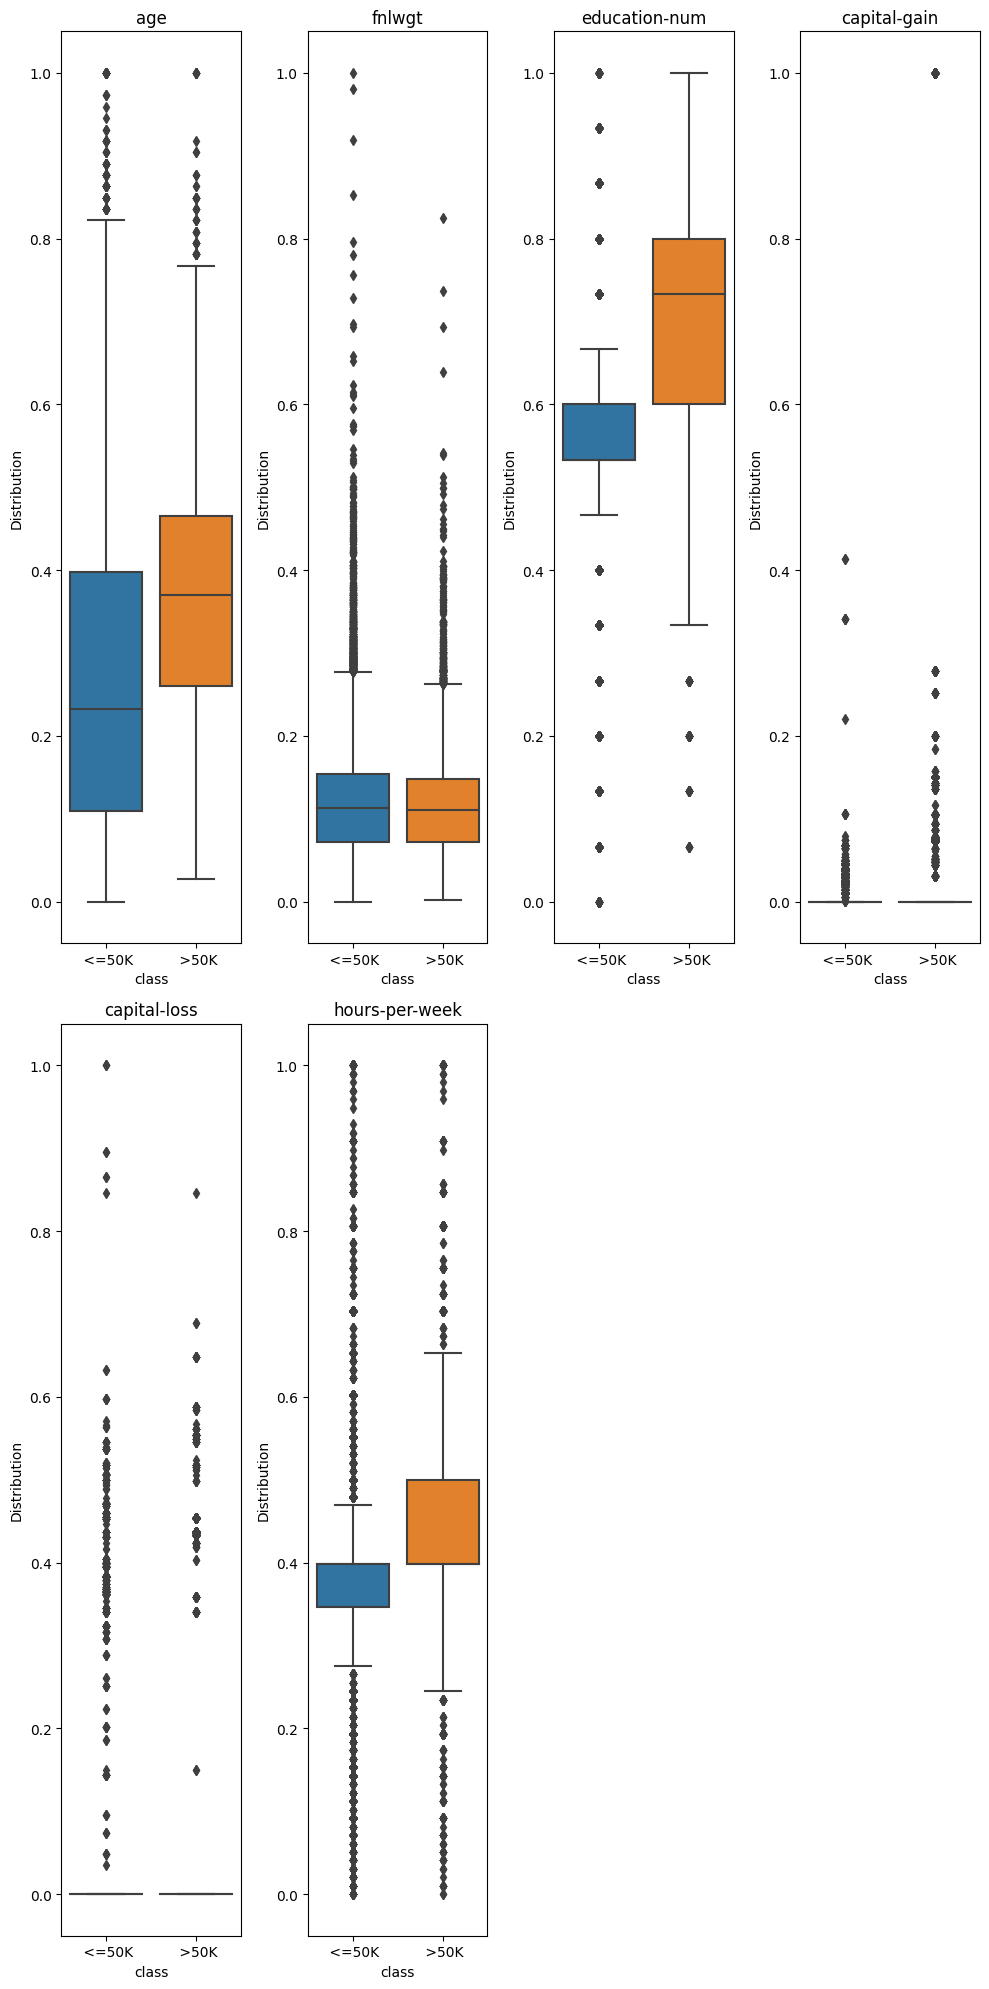

In [16]:
# check outliers in the scaled data
visualize_outliers(scaled_train_df)

# Check Histogram For Distributions

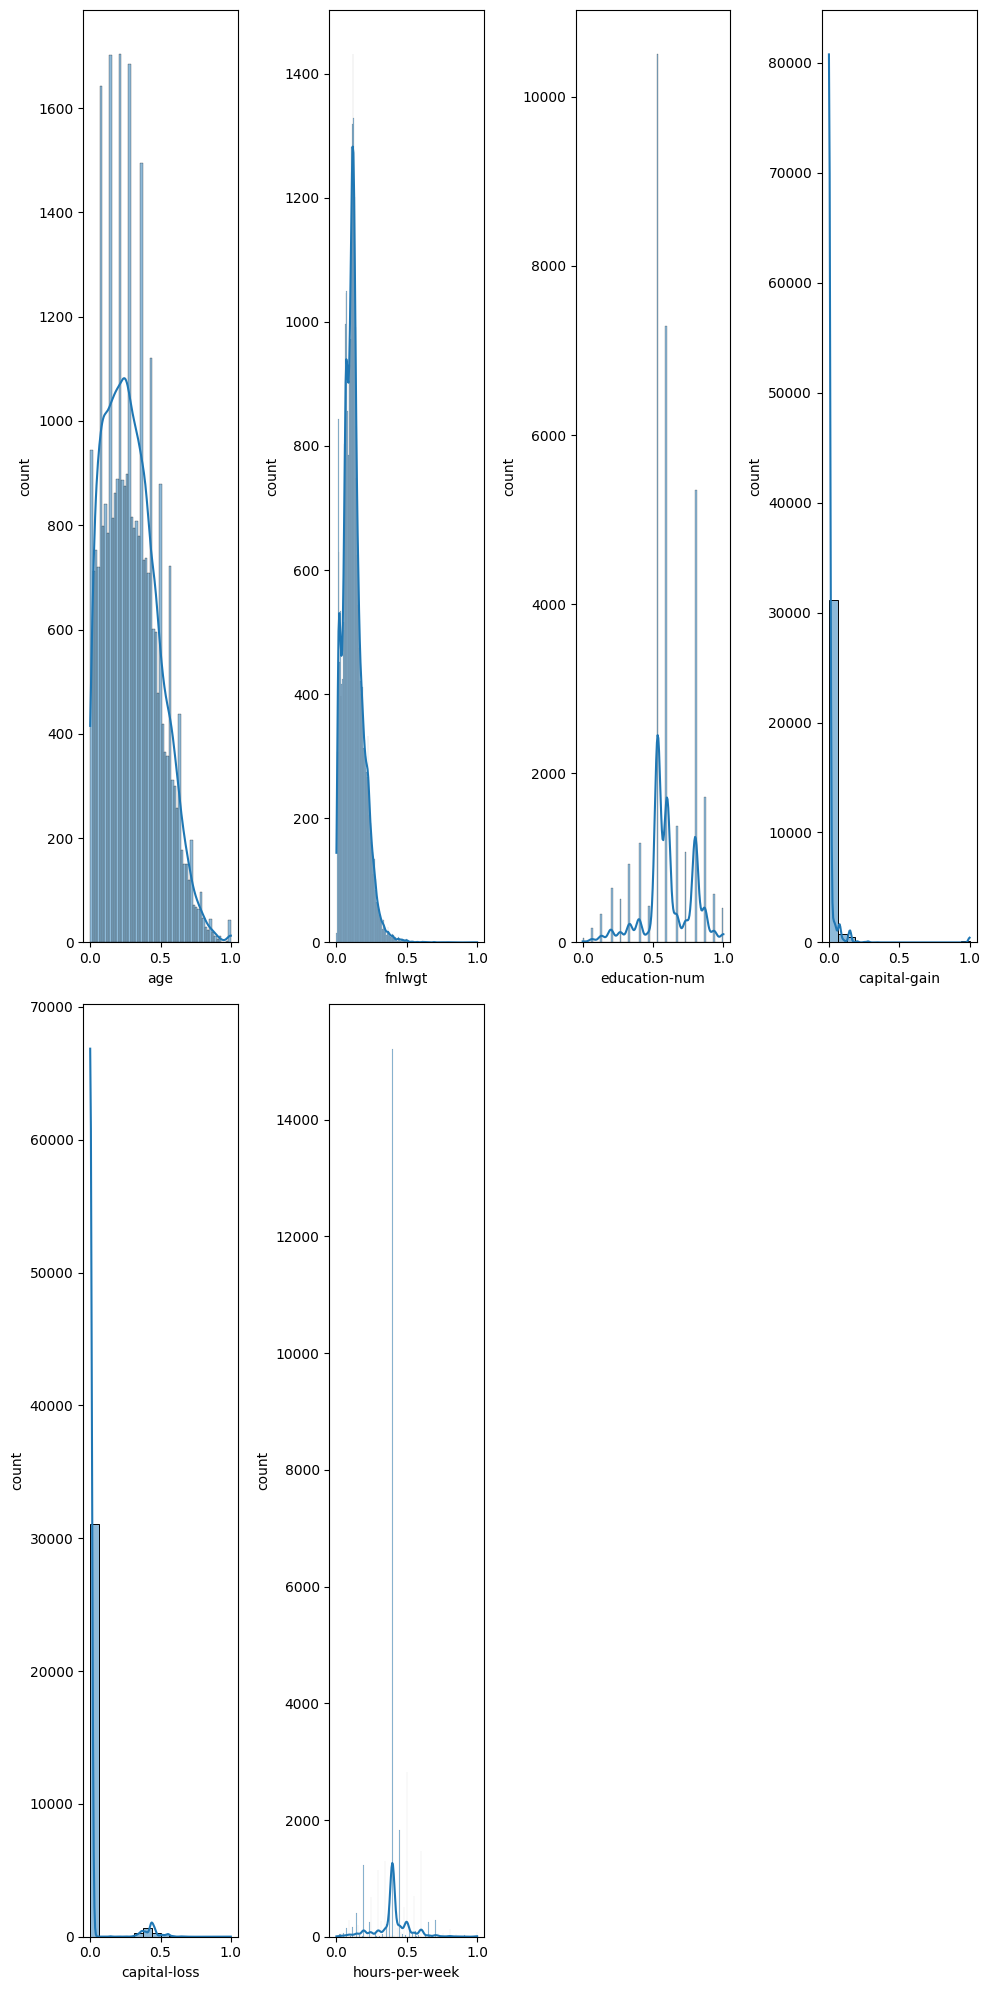

In [17]:
# check the histogram
show_histogram(scaled_train_df)

# Handle Odd Features That May Affect the Model

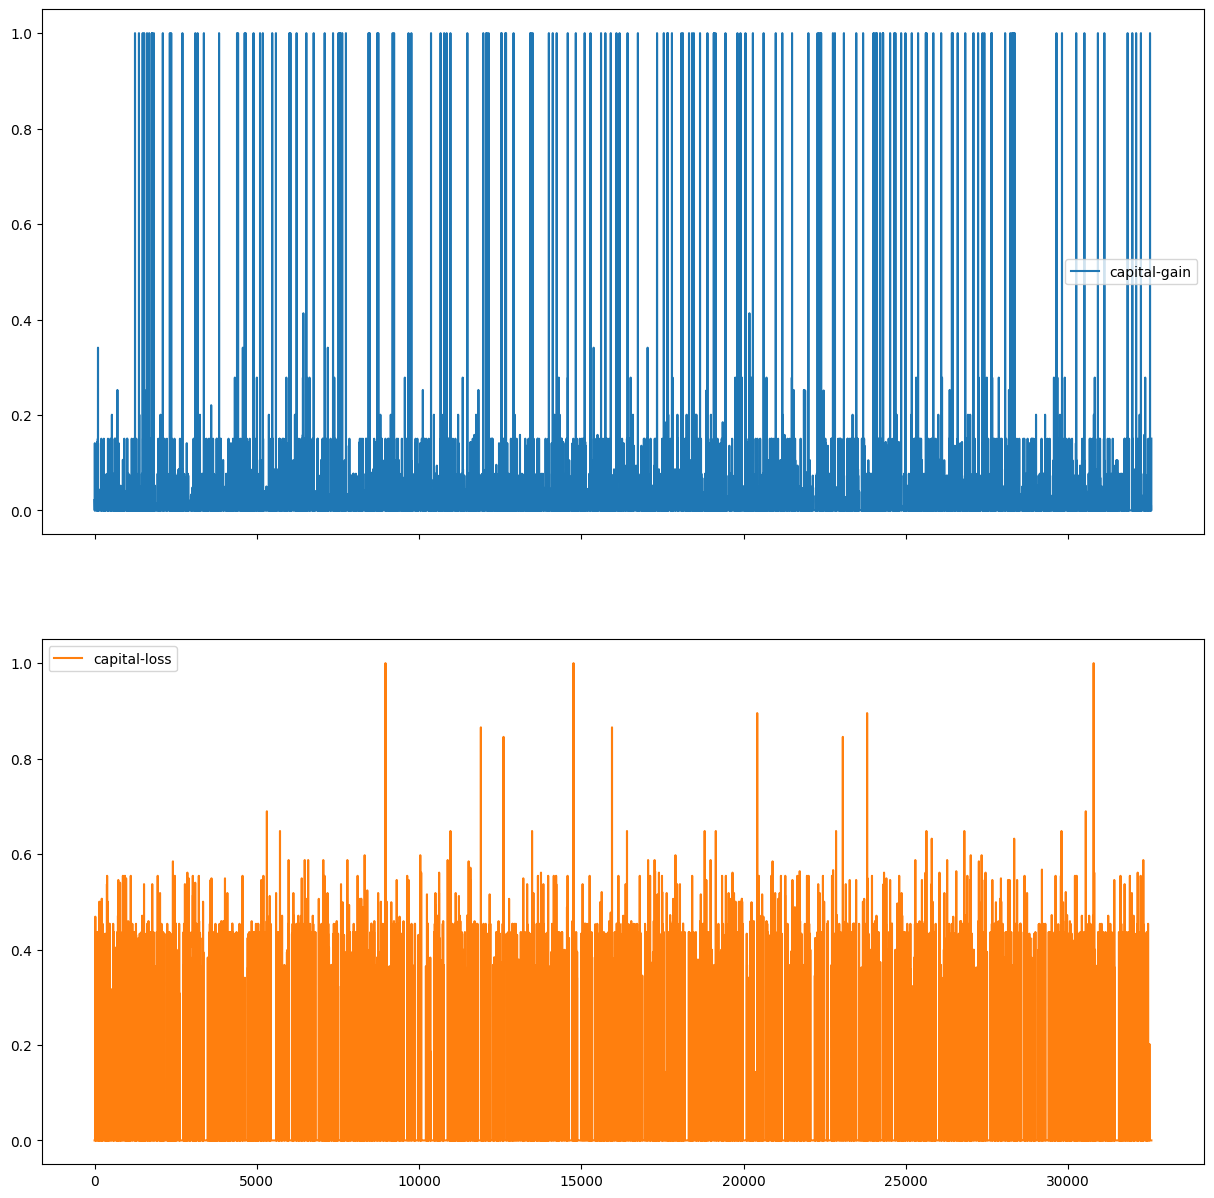

In [18]:
weird_features = ['capital-gain', 'capital-loss']
scaled_train_df[weird_features].plot(subplots=True, figsize=(15,15));

In [19]:
scaled_train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba,<=50K


# Data Manipulation

In [123]:
x = scaled_train_df.drop('class', axis = 1)
y = scaled_train_df[['class']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Identify categorical columns

categorical_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categorical columns in X_train
catTrain = []
catTest = []
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Fit and transform on training data
    catTrain.append(label_encoder.fit_transform(X_train[col]))

    # Only transform on testing data
    catTest.append(label_encoder.transform(X_test[col]))
catTrain = pd.DataFrame(np.array(catTrain).T, columns=categorical_cols)
catTest = pd.DataFrame(np.array(catTest).T, columns=categorical_cols)

label_encoder = LabelEncoder()
# Concatenate numerical and encoded categorical columns
X_train_encoded = pd.concat([X_train.select_dtypes(include=np.number), X_train[categorical_cols]], axis=1)
X_test_encoded = pd.concat([X_test.select_dtypes(include=np.number), X_test[categorical_cols]], axis=1)

In [21]:
(catTrain.head())

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,2,9,4,10,1,4,0,39
1,4,8,2,4,0,4,1,39
2,6,6,5,3,1,4,1,39
3,4,8,2,5,0,4,1,39
4,4,15,0,8,1,4,1,39


By performing this data preprocessing and encoding step, the code ensures that the categorical columns in the training and test data are converted into numerical labels.

This enables machine learning algorithms to process the data effectively. The numerical and encoded categorical features are then used for model training and evaluation.

In [22]:
imputer = SimpleImputer(strategy='most_frequent')  # You can choose different imputation strategies like 'mean', 'median', 'most_frequent', etc.

X_train = imputer.fit_transform(X_train_encoded)
X_test = imputer.transform(X_test_encoded)

# Apply SMOTE to the training data only - Doesnt make much of a difference
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


By using the SimpleImputer with the specified strategy, the code replaces missing values in the training and test data with the median of each respective column.

This helps in handling missing data and ensures that the imputed data is ready for further processing or model training.

# Build models

In [23]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.005, random_state=42, loss='log_loss')

# Support Vector Machine Classifier
svm_model = SVC(kernel='rbf', C=1.0, probability=True, gamma='scale', random_state=42)

cat_params = {
        'learning_rate': 0.005,
        'iterations': 50500,
        'depth': 4, #
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3, # 3, 30
        'random_seed': 4,
        'auto_class_weights': 'Balanced',
        'verbose' : 1000

    }
gbc = CatBoostClassifier(**cat_params)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier()
lgr_model = LogisticRegression(max_iter = 1000)

NameError: ignored

In [ ]:
gb_model.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))
svm_model.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))
lgr_model.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))
gbc.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))
rf.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))
dt.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))

By calling the fit method on each model with the training data, the models are trained on the provided features and corresponding target values.

After this step, the models are ready to make predictions on new, unseen data using the learned patterns from the training phase.

In [ ]:
gb_predictions = gb_model.predict_proba(X_test)
svm_predictions = svm_model.predict_proba(X_test)
cb_predictions = gbc.predict_proba(X_test)
rf_predictions = rf.predict_proba(X_test)
dt_predictions = dt.predict_proba(X_test)
lgr_predictions = lgr_model.predict_proba(X_test)

By calling the predict_proba method on each model with the test data, the models generate the probability estimates for each class.

These probability estimates can be used for various purposes such as evaluating model performance or making decisions based on the predicted probabilities.

In [ ]:
# Soft Voting (combines predicted probabilities)
ensemble_model = VotingClassifier(estimators=[('gb', gb_model), ('svm', svm_model), ('cat', gbc), ('rf', rf), ('dt', dt), ('lgr', lgr_model)], voting='soft')

By creating an ensemble model with soft voting, the code combines the predicted probabilities from multiple individual models to make a final prediction.

The ensemble model takes advantage of the collective knowledge of the individual models to potentially improve overall prediction performance.

In [ ]:
ensemble_model.fit(X_train, np.ravel(np.where(y_train['class'] == ' >50K', 1, 0)))

Fitting combined models.

# Testing

In [ ]:
ensemble_predictions = ensemble_model.predict_proba(X_test)

Predicting using test data.

In [ ]:
# Generate thresholds
num_thresholds = 100
thresholds = np.linspace(0, 1, num_thresholds)

# Initialize variables for optimal threshold and corresponding metric
best_f1 = 0
optimal_threshold = 0

# Iterate over thresholds and compute evaluation metrics
y_testB = np.where(y_test['class'] == ' >50K', 1, 0)
j = 0
for threshold in thresholds:
    # Convert probabilities into class labels based on threshold
    predicted_labels = np.where(np.array(ensemble_predictions) >= threshold, 1, 0)

    # Calculate evaluation metric (e.g., F1-score) using the true labels (y_test) and predicted labels
    f1 = f1_score(y_testB, predicted_labels[:, 1])
    j += 1
    # Update optimal threshold and metric if a higher F1-score is achieved
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1-score:", best_f1)


The code iterates over different thresholds and computes the F1-score for each threshold.

It finds the optimal threshold that maximizes the F1-score and prints the corresponding threshold and the best F1-score achieved.

In [ ]:
gb_accuracy = accuracy_score(y_testB, np.where(gb_predictions[:, 1] > optimal_threshold, 1, 0))
svm_accuracy = accuracy_score(y_testB, np.where(svm_predictions[:, 1] > optimal_threshold, 1, 0))
cat_accuracy = accuracy_score(y_testB, np.where(cb_predictions[:, 1] > optimal_threshold, 1, 0))
rf_accuracy = accuracy_score(y_testB, np.where(rf_predictions[:, 1] > optimal_threshold, 1, 0))
dt_accuracy = accuracy_score(y_testB, np.where(dt_predictions[:, 1] > optimal_threshold, 1, 0))
lgr_accuracy = accuracy_score(y_testB, np.where(lgr_predictions[:, 1] > optimal_threshold, 1, 0))
ensemble_accuracy = accuracy_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

print("Gradient Boosting Accuracy:", gb_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("CatBoost Accuracy:", cat_accuracy)
print("Rf Accuracy:", rf_accuracy)
print("Dt Accuracy:", dt_accuracy)
print("Lgr Accuracy:", lgr_accuracy)
print("Ensemble Accuracy:", ensemble_accuracy)

Gradient Boosting Accuracy: 0.85

The Gradient Boosting model achieves an accuracy of approximately 80.58% on the test data. It performs moderately well in predicting the target variable.

SVM Accuracy: 0.82

The Support Vector Machine (SVM) model achieves an accuracy of approximately 81.65% on the test data. It performs slightly better than the Gradient Boosting model in terms of accuracy.

CatBoost Accuracy: 0.82

The CatBoost model achieves an accuracy of approximately 82.33% on the test data. It performs better than both the Gradient Boosting and SVM models in terms of accuracy.

Random Forest Accuracy: 0.86

The Random Forest model achieves an accuracy of approximately 85.72% on the test data. It outperforms the previous three models in terms of accuracy.

Ensemble Accuracy: 0.86

The Ensemble model, which combines the predictions of multiple models using soft voting, achieves an accuracy of approximately 86.70% on the test data. It performs better than all individual models in terms of accuracy.

### Accuracy alone may not provide a complete picture of model performance, and other evaluation metrics should be considered as well

In [ ]:


precision = precision_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
recall = recall_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
f1 = f1_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
auroc = roc_auc_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUROC Score:', auroc)

In [ ]:
# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Precision: 0.71

Precision is a measure of the model's ability to correctly identify positive instances out of all instances predicted as positive. In this case, the precision score of approximately 0.72 indicates that when the model predicts a positive outcome, it is correct around 72% of the time.

Recall: 0.75

Recall (also known as sensitivity or true positive rate) measures the model's ability to correctly identify positive instances out of all actual positive instances. The recall score of approximately 0.74 suggests that the model can capture around 74% of the actual positive instances.

F1 Score: 0.73

The F1 score is the harmonic mean of precision and recall, providing a balanced measure of a model's performance. With an F1 score of approximately 0.73, the model achieves a reasonable balance between precision and recall.

AUROC Score: 0.83

AUROC (Area Under the Receiver Operating Characteristic Curve) is a measure of the model's ability to distinguish between positive and negative instances across different probability thresholds. The AUROC score of approximately 0.82 indicates a good level of discrimination ability for the model.

### The specific context and requirements of the problem at hand when interpreting these metrics. For example, depending on the specific application, precision or recall might be of higher importance. Therefore, it's recommended to consider these metrics along with other domain-specific considerations to assess the model's effectiveness.

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Define class labels
class_labels = ['Negative', 'Positive']

# Create labeled confusion matrix plot
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The plot visually represents the confusion matrix, which provides insights into the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [ ]:
# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted scores or probabilities
fpr, tpr, thresholds = roc_curve(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Calculate the AUROC score
auroc = roc_auc_score(y_testB, np.where(ensemble_predictions[:, 1] > optimal_threshold, 1, 0))

# Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The resulting plot shows the ROC curve, which visualizes the trade-off between the true positive rate and the false positive rate at different classification thresholds.

The AUROC score is displayed as a label on the plot, providing a single metric to summarize the overall performance of the classifier. The dashed line represents the ROC curve of a random classifier, serving as a reference for comparison.

With a score of 0.82 we can assume that the modekl performs very well, but depending on the problem and data set other methods may prove better.

# Overall Summary

Data Preprocessing:

The code includes preprocessing steps such as scaling, encoding categorical variables, and imputing missing values using different techniques like StandardScaler, QuantileTransformer, LabelEncoder, and SimpleImputer. These steps aim to prepare the data for modeling and ensure it is in a suitable format for the machine learning algorithms.

Model Training:

Several classification models are used, including Gradient Boosting, Support Vector Machine (SVM), CatBoost, and Random Forest. These models are fitted on the preprocessed training data using the fit method.

Ensemble Model:

An ensemble model is created using the VotingClassifier, which combines the predictions from multiple base models (Gradient Boosting, SVM, CatBoost, and Random Forest) using a soft voting strategy.

Model Evaluation:

Various evaluation metrics are calculated to assess the performance of the models. These metrics include accuracy, precision, recall, F1 score, and AUROC score.

Confusion Matrix:

The confusion matrix is visualized to provide insights into the model's performance in terms of true positives, true negatives, false positives, and false negatives.

ROC Curve:

The ROC curve is plotted to illustrate the trade-off between true positive rate and false positive rate at different classification thresholds. The AUROC score is calculated as a summary metric for the ROC curve, indicating the model's ability to distinguish between positive and negative samples.
Based on the provided results, it appears that the ensemble model achieved the highest accuracy, followed by Random Forest, CatBoost, SVM, and Gradient Boosting. The ensemble model's superior performance suggests that combining the predictions from multiple models can lead to improved classification results. Additionally, the F1 score and AUROC score provide insights into the model's precision, recall, and overall discriminative ability.

# Conclusion

It can be concluded that the Ensemble model outperforms the individual models (Random Forest, CatBoost, SVM, and Gradient Boosting) in terms of accuracy, precision, recall, F1 score, and AUROC score. It shows a good balance between correctly identifying positive instances and avoiding false positives.

Therefore, the Ensemble model can be considered the most effective model for this classification task.

In [ ]:
!pip install category_encoders

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import TimeSeriesSplit
import category_encoders as ce

#X = scaled_train_df.drop('SalePrice', axis=1)
#y = scaled_train_df['SalePrice']
# Define the number of splits and create the TimeSeriesSplit object
#y_test = np.where(y_test['class'] == ' >50K', 1, 0)
y_train = np.where(y_train['class'] == ' >50K', 1, 0)
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)
time_steps = 10
encoder = ce.OrdinalEncoder(handle_unknown='return_nan')
encoder.fit(scaled_train_df[cat_cols])
  # Encode categorical columns in X_train
  # Transform the train and test data
X[cat_cols] = encoder.transform(X[cat_cols])
num_features = X_train.shape[1]
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(time_steps, num_features), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Cross validation
v = 4
for trainIndex, testIndex in tscv.split(X_train):
  #random.seed(v)
  #XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3)
  XTrain, yTrain = X_train, y_train
  XTest, yTest = X_test, y_test
  # Reshape the data for LSTM
  samplesTrain, _ = XTrain.shape
  samplesTest, _ = XTest.shape
  reshapeTrain = array(XTrain)
  reshapeTest = array(XTest)
  reshapeTrainY = array(yTrain)
  reshapeTestY = array(yTest)
  # reshape the array
  # reshape the array
  XTrainReshaped = np.array([XTrain[i:i + time_steps] for i in range(len(XTrain) - time_steps + 1)])
  XTestReshaped = np.array([XTest[i:i + time_steps] for i in range(len(XTest) - time_steps + 1)])
  yTrainReshaped = yTrain[time_steps - 1 :]
  yTestReshaped = yTest[time_steps - 1 :]

  """XTrainReshaped = reshapeTrain.astype('float32').reshape(len(XTrainReshaped), time_steps, num_features)
  XTestReshaped = reshapeTest.astype('float32').reshape(len(XTestReshaped), time_steps, num_features)
  yTrainReshaped = reshapeTrainY.astype('float32').reshape(len(yTrainReshaped), num_features, 1)
  yTestReshaped = reshapeTestY.astype('float32').reshape(len(yTestReshaped), num_features, 1)
"""

  # Train the model
  history = model.fit(XTrainReshaped, yTrainReshaped, epochs=10, verbose=1, validation_data=(XTestReshaped, yTestReshaped))
  v += 1

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print(history.history.keys())


In [ ]:
!pip install tensorflow
!pip install tensorflow-recommenders


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import layers
import tensorflow_recommenders as tfrs


In [ ]:
class HouseFeatureTower(tf.keras.layers.Layer):
    def __init__(self, layer_sizes):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, input_shape=(layer_sizes[0], layer_sizes[1]), return_sequences=True),
            tf.keras.layers.Dense(units=32),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

    def call(self, inputs):
        print(f'HouseFeatureTower input shape: {inputs.shape}')  # Add this line
        return self.encoder(inputs)
        print(f'output shape in HouseFeatureTower call: {output.shape}')

In [ ]:
class SalePriceTower(tf.keras.layers.Layer):
    def __init__(self, layer_sizes):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, input_shape=(layer_sizes[0], layer_sizes[1]), return_sequences=True),
            tf.keras.layers.Dense(units=32),
            tf.keras.layers.Dense(1, activation='sigmoid')
])
    def call(self, inputs):
        print(f'Q input shape: {inputs.shape}')  # Add this line
        return self.encoder(inputs)
        print(f'output shape in Q call: {output.shape}')

In [ ]:


class HousePricePredictionModel(tfrs.models.Model):
    def __init__(self, layer_sizesN, layer_sizesC):
        super(HousePricePredictionModel, self).__init__()
        self.query_tower = HouseFeatureTower(layer_sizesN)
        self.candidate_tower = SalePriceTower(layer_sizesC)
        self.lstm1N = layers.LSTM(64, return_sequences=False)  # LSTM for the output of query_tower
        self.lstm1C = layers.LSTM(32, return_sequences=False)  # LSTM for the output of candidate_tower
        self.concatenate = layers.Concatenate(axis=-1)
        self.dense = layers.Dense(1, activation='sigmoid')  # Adjust the number of units and activation function as necessary
        self.final_dense = layers.Dense(1, activation='sigmoid')

    def compute_loss(self, y_true, y_pred):
        # Use binary cross-entropy as the loss function
        y_pred = tf.keras.activations.sigmoid(y_pred)
        loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return loss


    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            y = tf.reshape(y, [-1, 1])
            loss = self.compute_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}



    def test_step(self, data):
        # Unpack the data
        x, y_true = data

        # Compute predictions
        y_pred = self(x, training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss(y_true, y_pred, regularization_losses=self.losses)

        # Update the metrics.
        self.compiled_metrics.update_state(y_true, y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}
    def call(self, inputs, training=False):
        q = inputs[0]
        c = inputs[1]
        query_embeddings = self.query_tower(q)
        candidate_embeddings = self.candidate_tower(c)
        print("Query embeddings shape:", query_embeddings.shape)
        print("Candidate embeddings shape:", candidate_embeddings.shape)
        # Expand dimensions to make the output 3D for LSTM layer
        #query_embeddings = tf.expand_dims(query_embeddings, 1)
        #candidate_embeddings = tf.expand_dims(candidate_embeddings, 1)

        lstm_outN = self.lstm1N(query_embeddings)
        lstm_outC = self.lstm1C(candidate_embeddings)
        combined = self.concatenate([lstm_outN, lstm_outC])
        x = self.dense(combined)
        output = self.final_dense(x)
        return output


In [25]:
train = pd.read_csv('/content/drive/MyDrive/au_train.csv')
test = pd.read_csv('/content/drive/MyDrive/au_test.csv')
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
# select numerical and categorical features
num_cols = train.select_dtypes(include=np.number).columns.tolist()
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Id' in num_cols:
    num_cols.remove('Id')
print(f"Total numerical features: {len(num_cols)}")
print(f"Total categorical features: {len(cat_cols)}")
print(num_cols)
print(cat_cols)

Train shape: (32561, 15)
Test shape: (16281, 15)
Total numerical features: 6
Total categorical features: 9
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']


In [26]:
std_scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
robust_scaler = preprocessing.RobustScaler()
quantile_scaler = preprocessing.QuantileTransformer(n_quantiles=60, output_distribution='normal')

In [27]:
scaled_train_df = train.copy(deep=True)
scaled_test_df = test.copy(deep=True)
scaled_train_df[num_cols] = mm_scaler.fit_transform(scaled_train_df[num_cols])
scaled_test_df[num_cols] = mm_scaler.fit_transform(scaled_test_df[num_cols])

In [124]:
from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

X = scaled_train_df.drop('class', axis = 1)
y = scaled_train_df[['class']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3)
timeSteps = 10
# Encode categorical columns in X_train
catTrain = []
catTest = []
# Define the encoder
encoder = OneHotEncoder(handle_unknown='ignore')  # 'ignore' helps to handle categorical levels present in test but not in train

# Fit the encoder on training data
if ('class' in cat_cols):
  cat_cols.remove('class')
encoder.fit(XTrain[cat_cols])

# Transform both training and test datasets
catTrain = encoder.transform(XTrain[cat_cols])
catTest = encoder.transform(XTest[cat_cols])

catTrain_df = pd.DataFrame(catTrain.toarray(), columns=encoder.get_feature_names_out(input_features=cat_cols))
catTest_df = pd.DataFrame(catTest.toarray(), columns=encoder.get_feature_names_out(input_features=cat_cols))
num_cols = XTrain.select_dtypes(include=[np.number]).columns.tolist()
# Select numerical columns
numTrain = XTrain[num_cols]
numTest = XTest[num_cols]

numTrainR = np.array([numTrain[i:i + timeSteps] for i in range(len(numTrain) - timeSteps + 1)])
numTestR = np.array([numTest[i:i + timeSteps] for i in range(len(numTest) - timeSteps + 1)])
catTrainR = np.array([catTrain_df[i:i + timeSteps] for i in range(len(catTrain_df) - timeSteps + 1)])
catTestR = np.array([catTest_df[i:i + timeSteps] for i in range(len(catTest_df) - timeSteps + 1)])
yTrainB = np.where(yTrain == ' >50K', 1, 0)
yTestB = np.where(yTest == ' >50K', 1, 0)
yTrainReshaped = yTrainB[timeSteps - 1 :]
yTestReshaped = yTestB[timeSteps - 1 :]

layer_sizesC=[timeSteps, catTrainR.shape[2]]
layer_sizesN=[timeSteps, numTrainR.shape[2]]

In [ ]:
# Instantiate the model
model = HousePricePredictionModel(layer_sizesN, layer_sizesC)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [48]:
summary(catTrain_df)

Data shape: (22792, 102)

Summary of columns missing values
Series([], dtype: object)



,Data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
workclass_ ?,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
workclass_ Federal-gov,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
workclass_ Local-gov,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
workclass_ Never-worked,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
workclass_ Private,float64,0,0.0,2,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
native-country_ Thailand,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
native-country_ Trinadad&Tobago,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0
native-country_ United-States,float64,0,0.0,2,0.0,1.0,1.0,1.0,1.0
native-country_ Vietnam,float64,0,0.0,2,0.0,1.0,0.0,0.0,0.0


In [ ]:
model.fit([numTrainR, catTrainR], yTrainReshaped, epochs=10, verbose=1, validation_data=([numTestR,catTestR], yTestReshaped))


In [108]:
# Encode categorical columns in X_train
numTest = []
catTest = []
# Define the encoder
encoder = OneHotEncoder(handle_unknown='ignore')  # 'ignore' helps to handle categorical levels present in test but not in train

# Fit the encoder on training data
if ('class' in cat_cols):
  cat_cols.remove('class')
encoder.fit(scaled_test_df[cat_cols])
# Transform both training and test datasets
catTest = encoder.transform(scaled_test_df[cat_cols])
catTest_df = pd.DataFrame(catTest.toarray(), columns=encoder.get_feature_names_out(input_features=cat_cols))


missing_col = set(catTrain_df.columns) - set(catTest_df.columns)
for col in missing_col:
    catTest_df[col] = 0

num_cols = scaled_test_df.select_dtypes(include=[np.number]).columns.tolist()
# Select numerical columns
numTest = scaled_test_df[num_cols]

numTestR = np.array([numTest[i:i + timeSteps] for i in range(len(numTest) - timeSteps + 1)])
catTestR = np.array([catTest_df[i:i + timeSteps] for i in range(len(catTest_df) - timeSteps + 1)])

yTestB = np.where(scaled_test_df['class'] == ' >50K', 1, 0)


In [ ]:
predictions = model((numTestR, catTestR))

In [81]:
# Generate thresholds
num_thresholds = 100
thresholds = np.linspace(0, 1, num_thresholds)

# Initialize variables for optimal threshold and corresponding metric
best_f1 = 0
optimal_threshold = 0

# Iterate over thresholds and compute evaluation metrics
j = 0
for threshold in thresholds:
    # Convert probabilities into class labels based on threshold
    predicted_labels = np.where(np.array(predictions) >= threshold, 1, 0)

    # Calculate evaluation metric (e.g., F1-score) using the true labels (y_test) and predicted labels
    f1 = f1_score(yTestB, predicted_labels)
    j += 1
    # Update optimal threshold and metric if a higher F1-score is achieved
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1-score:", best_f1)


NameError: ignored

In [ ]:
precision = precision_score(yTestB, np.where(predictions > optimal_threshold, 1, 0))
recall = recall_score(yTestB, np.where(predictions > optimal_threshold, 1, 0))
f1 = f1_score(yTestB, np.where(predictions > optimal_threshold, 1, 0))
auroc = roc_auc_score(yTestB, np.where(predictions > optimal_threshold, 1, 0))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUROC Score:', auroc)

In [ ]:
print(yTestReshaped)

In [125]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
numTrain = numTrain.reset_index(drop=True)
catTrain_df = catTrain_df.reset_index(drop=True)
XTrain = pd.concat([numTrain, catTrain_df], axis=1).reset_index(drop=True)
numTest = numTest.reset_index(drop=True)
catTest_df = catTest_df.reset_index(drop=True)
XTest = pd.concat([numTest, catTest_df], axis=1).reset_index(drop=True)

# Create a Gaussian Classifier
clf = BernoulliNB()

# Train the model using the training sets
clf.fit(XTrain, yTrainB)

# Predict the response for the test dataset
y_pred = clf.predict(XTest)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
# Calculate accuracy
accuracy = accuracy_score(yTestB, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 78.86%


In [118]:
#summary(XTest)
summary(XTest)

Data shape: (9769, 107)

Summary of columns missing values
Series([], dtype: object)



,Data type,#missing,%missing,#unique,min,max,first quartile,second quartile,third quartile
age,float64,0,0.0,70,-1.000000,2.65000,-0.450000,0.000000,0.550000
fnlwgt,float64,0,0.0,8291,-1.371184,8.79208,-0.505754,-0.008597,0.476146
education-num,float64,0,0.0,16,-3.000000,2.00000,-0.333333,0.000000,0.666667
capital-gain,float64,0,0.0,103,0.000000,99999.00000,0.000000,0.000000,0.000000
capital-loss,float64,0,0.0,70,0.000000,3900.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
native-country_ Thailand,float64,0,0.0,2,0.000000,1.00000,0.000000,0.000000,0.000000
native-country_ Trinadad&Tobago,float64,0,0.0,2,0.000000,1.00000,0.000000,0.000000,0.000000
native-country_ United-States,float64,0,0.0,2,0.000000,1.00000,1.000000,1.000000,1.000000
native-country_ Vietnam,float64,0,0.0,2,0.000000,1.00000,0.000000,0.000000,0.000000
